In [108]:
import kaggle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [109]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [110]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [111]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [112]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [113]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [114]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [115]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [116]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [117]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [118]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [119]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [120]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [121]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [122]:
test_df['y'].min()

0

In [123]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [124]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [125]:
import seaborn as sns

<AxesSubplot:>

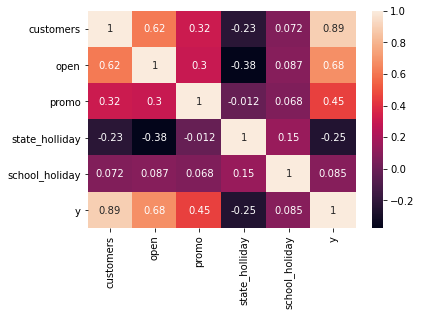

In [126]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

array([[<AxesSubplot:xlabel='customers', ylabel='customers'>,
        <AxesSubplot:xlabel='open', ylabel='customers'>,
        <AxesSubplot:xlabel='promo', ylabel='customers'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='customers'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='customers'>,
        <AxesSubplot:xlabel='y', ylabel='customers'>],
       [<AxesSubplot:xlabel='customers', ylabel='open'>,
        <AxesSubplot:xlabel='open', ylabel='open'>,
        <AxesSubplot:xlabel='promo', ylabel='open'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='open'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='open'>,
        <AxesSubplot:xlabel='y', ylabel='open'>],
       [<AxesSubplot:xlabel='customers', ylabel='promo'>,
        <AxesSubplot:xlabel='open', ylabel='promo'>,
        <AxesSubplot:xlabel='promo', ylabel='promo'>,
        <AxesSubplot:xlabel='state_holliday', ylabel='promo'>,
        <AxesSubplot:xlabel='school_holiday', ylabel='promo'>,
       

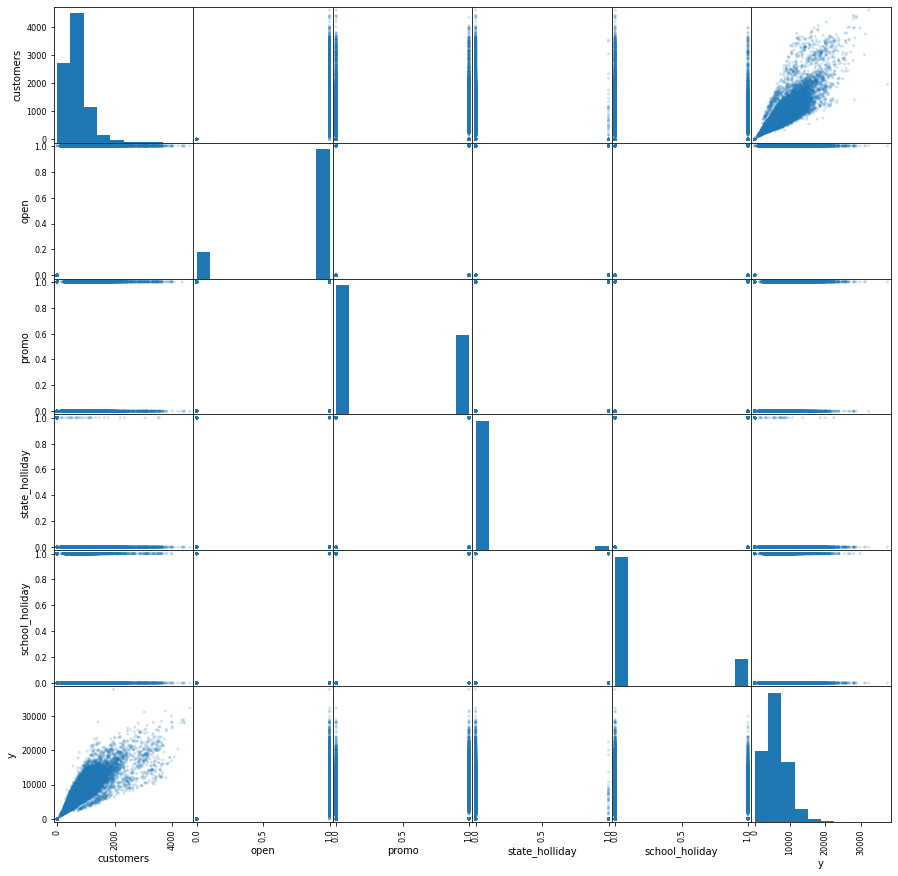

In [127]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

#Feature Eng

In [128]:
display(train_df.head())
display(store_df.head())

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,1,1,0
1,128,2013-01-01,0,0,0,1,1,0
2,420,2013-01-01,0,0,0,1,1,0
3,225,2013-01-01,0,0,0,1,1,0
4,144,2013-01-01,0,0,0,1,1,0


,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN


In [129]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [130]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [131]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

### One hot encoding

In [132]:
# Merger les jeux de données train_df et store_df selon l'id en donnant des valeurs binaires pour chaque type de magasin...

train_df_merged = train_df
test_df_merged = test_df
for col in ['store_type', 'assortment', 'promo_interval']:
    df1 = pd.get_dummies(store_df[col], prefix=col[:5])
    df1['id'] = store_df['id']
    train_df_merged = train_df_merged.join(df1.set_index('id'), on='id')
    test_df_merged = test_df_merged.join(df1.set_index('id'), on='id')

test_df_merged


,id,date,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec"
0,1105,2013-01-01,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0
1,306,2013-01-01,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0
2,1115,2013-01-01,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1
3,506,2013-01-01,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0
4,877,2013-01-01,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0
203438,323,2015-07-31,716,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0
203439,912,2015-07-31,806,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0
203440,276,2015-07-31,575,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1


In [133]:
#Day of week
train_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek

#Day of year
train_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear

#Supprimer la colonne Date 
train_df_new = train_df_merged.drop(columns=['date'])
test_df_new = test_df_merged.drop(columns=['date'])



display(train_df_new)

,id,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year
0,1042,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1
1,128,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
2,420,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
3,225,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1
4,144,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,684,1,1,0,1,9343,1,0,0,0,0,0,1,0,0,0,4,212
813763,796,769,1,1,0,1,8913,1,0,0,0,0,0,1,0,0,0,4,212
813764,230,1091,1,1,0,1,10988,0,0,0,1,0,0,1,0,0,0,4,212
813765,387,1402,1,1,0,1,14533,0,0,1,0,1,0,0,0,0,1,4,212


In [134]:
#train_df_new = train_df_new[train_df_new['customers'] > 0]

In [135]:
# Vérifier si train_df_new ne contient au final que des valeurs numériques

train_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                        True
customers                 True
open                      True
promo                     True
state_holliday            True
school_holiday            True
y                         True
store_a                   True
store_b                   True
store_c                   True
store_d                   True
assor_a                   True
assor_b                   True
assor_c                   True
promo_Feb,May,Aug,Nov     True
promo_Jan,Apr,Jul,Oct     True
promo_Mar,Jun,Sept,Dec    True
day_of_week               True
day_of_year               True
dtype: bool

<AxesSubplot:>

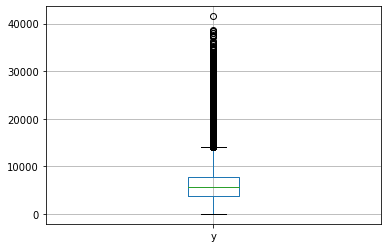

In [136]:
#train_df_new['ratio'] = 

train_df_new.boxplot(column = ['y'])

# Process and Prepare Data

In [137]:
# Separating the features and the target
X , y = train_df_new.drop(columns=['id','y']), train_df_new['y']

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}')

Input shape  : (813767, 17)
Target shape : (813767,)


In [138]:
train_df_new[(train_df_new['customers'] == 0) & (train_df_new['y']==0)]

,id,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year
0,1042,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1
1,128,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
2,420,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
3,225,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1
4,144,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811278,876,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,2,210
811875,292,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,2,210
811985,292,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,3,211
812122,876,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,3,211


In [139]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#X_train= X_train.to_numpy()
#X_valid= X_valid.to_numpy()
#y_train= y_train.to_numpy()
#y_valid= y_valid.to_numpy()


# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 651013
Validation size : 162754


# Train Models Pipeline

In [140]:
Models = dict()

In [141]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    #train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(mae(y_train, train_preds))
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        

### Linear Regression

In [106]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})

 -  Linear Regression best hyperparameters : {'copy_X': True, 'fit_intercept': True, 'normalize': False} 


 -  Linear Regression results on the train set:
985.5361120190823
 -  Linear Regression results on the valid set:
981.8212560391099


### Decision trees


In [36]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(2,10)),'min_samples_leaf':range(1,5)
                                })

 -  Decision Tree Regression best hyperparameters : {'max_depth': 9, 'min_samples_leaf': 2} 


 -  Decision Tree Regression results on the train set:
737.7702055170021
 -  Decision Tree Regression results on the valid set:
737.4068024356493


### Random Forest

In [ ]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42), 
                        grid = {'max_depth': range(10,100,50),
                                'min_samples_leaf':range(2,8,3),
                                'n_estimators': [100, 200]}
                        )

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {#'n_neighbors':range(1,7),
                                #'weights':['uniform','distance'],
                                })

### XGBoost

In [ ]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(),
                        grid = {'max_depth': [3, 4, 5, 6, 7]})

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

In [142]:
# Separating the features and the target
X, y = train_df_new.drop(columns=['y', 'id']), train_df_new['y']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}\n')
print(f'Target : \n{y}')

Input shape  : (813767, 17)
Target shape : (813767,)

Target : 
0             0
1             0
2             0
3             0
4             0
          ...  
813762     9343
813763     8913
813764    10988
813765    14533
813766     8941
Name: y, Length: 813767, dtype: int64


In [143]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = scaler.transform(test_df_new.drop(columns=['y', 'id']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

Train size : 651013
Validation size : 162754
Test size : 203442


In [144]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [ ]:
# Training params
nb_epochs = 50
model_hist = model.fit(x=X_train, y=y_train, validation_data=(X_valid,y_valid), batch_size=32, epochs=nb_epochs, verbose=1).history

Epoch 1/50
20345/20345 [==============================] - 74s 4ms/step - loss: 2376.1564 - mean_absolute_error: 2376.1564 - val_loss: 885.9729 - val_mean_absolute_error: 885.9729
Epoch 2/50
20345/20345 [==============================] - 77s 4ms/step - loss: 1344.1995 - mean_absolute_error: 1344.1995 - val_loss: 809.8192 - val_mean_absolute_error: 809.8192
Epoch 3/50
20345/20345 [==============================] - 80s 4ms/step - loss: 1290.5656 - mean_absolute_error: 1290.5656 - val_loss: 805.1924 - val_mean_absolute_error: 805.1924
Epoch 4/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1273.0626 - mean_absolute_error: 1273.0626 - val_loss: 792.6286 - val_mean_absolute_error: 792.6286
Epoch 5/50
20345/20345 [==============================] - 78s 4ms/step - loss: 1268.1528 - mean_absolute_error: 1268.1528 - val_loss: 798.6401 - val_mean_absolute_error: 798.6401
Epoch 6/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1262.0179 - mean_absolute_

In [ ]:
##Prediction
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
Models['Neural Network'] = {'model':model,
                             'scores':{'train':mae(y_train, train_preds),
                                       'valid' :mea(y_valid, valid_preds)}}
print("   -   MAE on the train set : {:.2f}%".format(Models['Neural Network']['scores']['train']))
print("   -   MAE on the test set : {:.2f}%".format(Models['Neural Network']['scores']['test']))

# Approch Results

<AxesSubplot:>

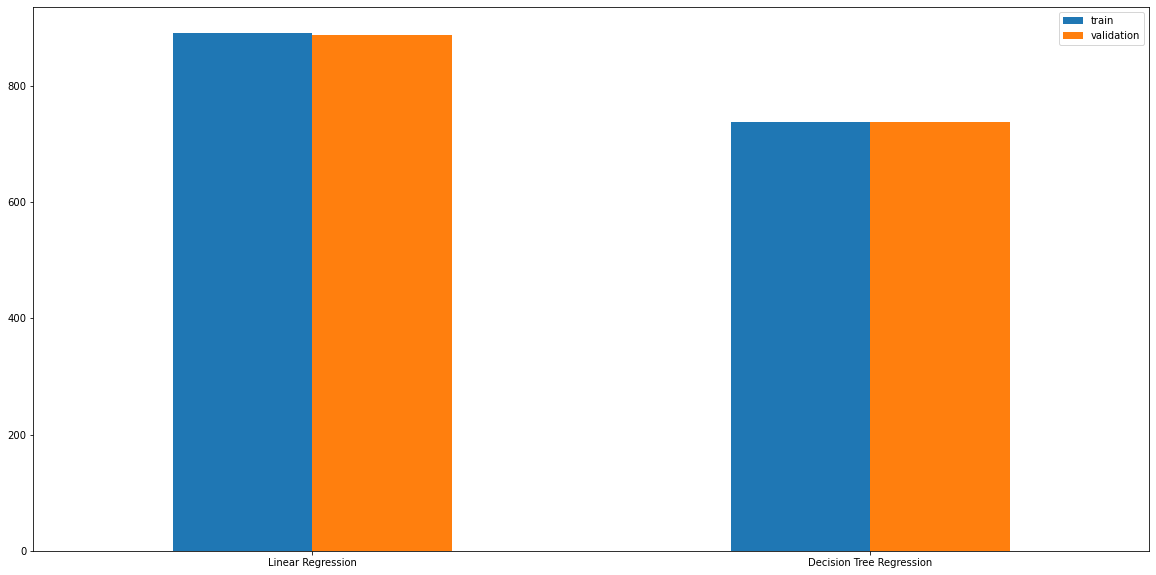

In [216]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

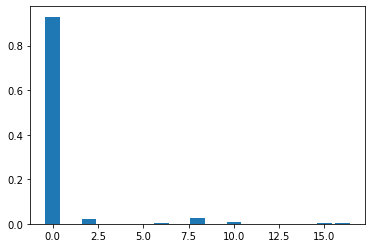

In [37]:
# visualize feature importance scores 
model = Models['Decision Tree Regression']['model'].best_estimator_
importance = model.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## BEST MODEL - trained on both train and valid set

In [78]:
best_model = DecisionTreeRegressor(max_depth= 9, min_samples_leaf= 4)
#best_model = XGBRegressor(max_depth=5)
#best_model = SVR(kernel='linear')

In [79]:
#Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#X_test = test_df_new.drop(columns=['id','y'])
X_test

array([[-1.36303834, -2.21077341, -0.7857722 , ..., -0.32603759,
        -0.99990725, -1.58715247],
       [-1.36303834, -2.21077341, -0.7857722 , ..., -0.32603759,
        -0.99990725, -1.58715247],
       [-1.36303834, -2.21077341, -0.7857722 , ...,  3.06713096,
        -0.99990725, -1.58715247],
       ...,
       [ 0.37223121,  0.45233039,  1.27263347, ..., -0.32603759,
         1.00233573,  0.65709856],
       [-0.12509791,  0.45233039,  1.27263347, ...,  3.06713096,
         1.00233573,  0.65709856],
       [ 0.18923132,  0.45233039,  1.27263347, ..., -0.32603759,
         1.00233573,  0.65709856]])

In [80]:
#Entrainement
best_model.fit(X,y)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=4)

In [104]:
X

array([[-0.08394048, -0.89844839, 29.87518126, ..., -0.32565127,
        -0.88144056, -1.59214648],
       [-0.69938725, -0.89844839, 29.87518126, ..., -0.32565127,
        -0.88144056, -1.59214648],
       [ 1.20924524, -0.89844839, 29.87518126, ..., -0.32565127,
        -0.88144056, -1.59214648],
       ...,
       [ 0.81805033,  1.11302999, -0.0334726 , ..., -0.32565127,
         0.85901962,  0.48981302],
       [ 1.59296508,  1.11302999, -0.0334726 , ...,  3.07076957,
         0.85901962,  0.48981302],
       [ 0.09795269,  1.11302999, -0.0334726 , ..., -0.32565127,
         0.85901962,  0.48981302]])

In [81]:
#test_preds = X_test.apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)
#X_test[:500].apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)

#Prediction
test_preds = best_model.predict(X_test)
test_preds

array([   0.        ,    0.        ,    0.        , ..., 7791.34979213,
       5518.1199765 , 6357.27489432])

In [83]:
#MAE
mae(y, best_model.predict(X))

737.7531627537693

## Save as .csv

In [84]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result

,y
index,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
203437,7236.169276
203438,8095.772099
203439,7791.349792


In [43]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')